# Poisson Kriging - Area to Point Kriging

## Table of Contents:

1. Load areal and point data,
2. Load semivariogram (regularized),
3. Build point-based map of better spatial resolution.

## Level: Advanced

## Changelog

| Date | Change description | Author |
|------|--------------------|--------|
| 2021-12-14 | Sill selection was upgraded: now optimal sill is derived from the grid search within `TheoreticalSemivariogram` class | @SimonMolinsky |
| 2021-12-13 | Changed behavior of `select_values_in_range()` function | @SimonMolinsky |
| 2021-12-11 | Behavior of `prepare_kriging_data()` function has benn changed | @SimonMolinsky |
| 2021-05-28 | Updated paths for input/output data | @SimonMolinsky |
| 2021-05-11 | Refactored TheoreticalSemivariogram class | @SimonMolinsky |
| 2021-03-31 | Update related to the change of semivariogram weighting. Updated cancer rates data. | @SimonMolinsky |

## Introduction

To start this tutorial it is required to understand concepts in the **Ordinary and Simple Kriging** and **Semivariogram Regularization** tutorials. The good idea is to end **Poisson Kriging - Centroid based** and **Poisson Kriging - Area to Area** tutorials before this one.

Poisson Kriging technique is used to model spatial count data. We are analyzing special case where data is counted over areas. Those areas may have irregular shapes and sizes beacuse they represent administrative regions. 

In this tutorial we try to predict rates of Breast Cancer in Pennsylvania counties. Along with areal data we use U.S. Census 2010 data for population blocks.

> Breast cancer rates data is stored in the shapefile in folder `sample_data/areal_data/cancer_data.shp`.

> Population blocks data is stored in the shapefile in folder `sample_data/population_data/cancer_population_base.shp`

This tutorial covers following steps:

1. Read and explore data,
2. Load semivariogram model,
3. Perform Area to Point smoothing of areal data.
4. Visualize points.

## 1) Read and explore data

In [1]:
import numpy as np
import pandas as pd

from pyinterpolate.variogram import TheoreticalVariogram
from pyinterpolate.processing.preprocessing.blocks import Blocks, PointSupport
from pyinterpolate.pipelines.deconvolution import smooth_area_to_point_pk

<AxesSubplot:>

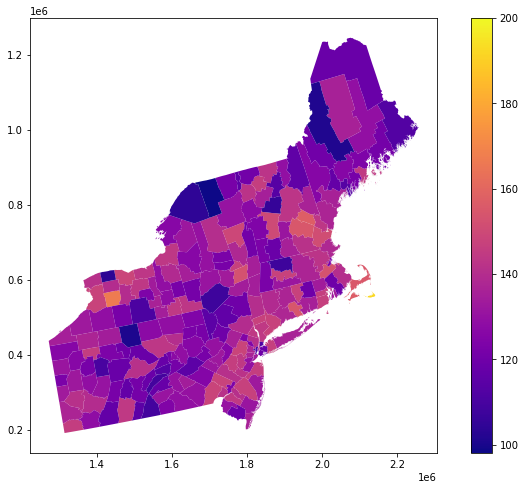

In [19]:
DATASET = 'samples/regularization/cancer_data.gpkg'
OUTPUT = 'samples/regularization/regularized_variogram.json'
POLYGON_LAYER = 'areas'
POPULATION_LAYER = 'points'
POP10 = 'POP10'
GEOMETRY_COL = 'geometry'
POLYGON_ID = 'FIPS'
POLYGON_VALUE = 'rate'

blocks = Blocks()
blocks.from_file(DATASET, value_col=POLYGON_VALUE, index_col=POLYGON_ID, layer_name=POLYGON_LAYER)

point_support = PointSupport()
point_support.from_files(point_support_data_file=DATASET,
                         blocks_file=DATASET,
                         point_support_geometry_col=GEOMETRY_COL,
                         point_support_val_col=POP10,
                         blocks_geometry_col=GEOMETRY_COL,
                         blocks_index_col=POLYGON_ID,
                         use_point_support_crs=True,
                         point_support_layer_name=POPULATION_LAYER,
                         blocks_layer_name=POLYGON_LAYER)

# Lets take a look into a map of areal counts

blocks.data.plot(column=blocks.value_column_name, cmap='plasma', vmax=200, legend=True, figsize=(12, 8))

#### Clarification: 

It is good idea to look into the spatial patterns in dataset and to visually check if our data do not have any NaN values. We use geopandas GeoDataFrame plot function for it with color map which is diverging color classes well.

## 2) Load semivariogram model

In this step we load regularized semivariogram from the tutorial **Semivariogram Regularization (Intermediate)**. You can always perform semivariogram regulariztion along with the Poisson Kriging but it is a very long process and it is more convenient to separate those two steps.

In [3]:
semivariogram = TheoreticalVariogram()  # Create TheoreticalSemivariogram object
semivariogram.from_json('output/regularized_model.json')  # Load regularized semivariogram

## 3) Perform Area to Point smoothing of areal data.

The process of map smoothing is straightforward.

=> **number of observations** (the most important parameter - how many neighbors are affecting your area of analysis),

Method returns `GeoDataFrame` with points and predicted values. It iteratively re-calculates each area risk and returns predictions per point. In Area to Area Kriging those predictions where aggregated, now we leave them and use them as a smooth map of areal risk.

In [6]:
smoothed = smooth_area_to_point_pk(semivariogram_model=semivariogram,
                                   blocks=blocks,
                                   point_support=point_support,
                                   number_of_neighbors=8,
                                   crs=blocks.data.crs,
                                   raise_when_negative_error=False,
                                   raise_when_negative_prediction=True)

 21%|██        | 45/217 [00:02<00:08, 19.58it/s]/home/szymon/Documents/Programming/Repositories/pyinterpolate-environment/pyinterpolate/pyinterpolate/kriging/models/block/weight.py:177: RuntimeWarning: invalid value encountered in double_scalars
  weighted_block_smv = weighted_semivars / np.sum(all_weights)
100%|██████████| 217/217 [00:12<00:00, 17.09it/s]


In [7]:
smoothed.head()

,area id,geometry,pred,err
0,25019.0,POINT (2117322.312 556124.507),0.101573,9.358192
1,25019.0,POINT (2134642.820 556124.507),193.510595,0.000000
2,36121.0,POINT (1424501.989 556124.507),4.652030,11.874605
3,36121.0,POINT (1424501.989 546124.507),5.092448,12.535179
4,36121.0,POINT (1433162.243 561124.507),17.586995,11.437867


## 4) Visualize data

The last step is data visualization. We use choropleth map from the GeoPandas package, but you can store smoothed map to shapefile of points and process it in a different place or with specific software (in our idea the best for it is **QGIS**).

<AxesSubplot:>

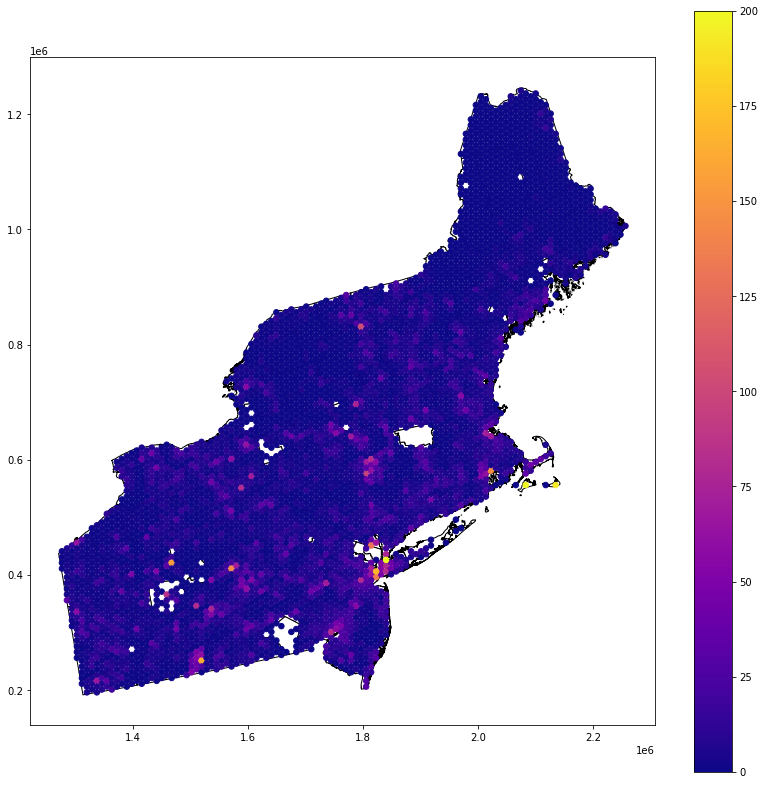

In [23]:
base = blocks.data.plot(figsize=(14, 14), color='white', edgecolor='black')
smoothed.plot(ax=base, column='pred', cmap='plasma', legend=True, markersize=30, vmax=200)

---

## Where to go?

### Next steps:

* [Poisson Kriging - Centroid based]()
* [Poisson Kriging - Area to Area]()

### Additional materials:

* [Semivariogram Regularization]()
* [Blocks to points Ordinary Kriging interpolation]()